# Data Science Final Project 


**College/University Name**: _CICCC - Cornerstone International Community College of Canada_  
**Course**: _Final Project_  
**Instructor**: _Derrick Park_  
**Student Name**: _Amir Lima Oliveira_  
**Submission Date**: _2025-09-26_  

---

### Project Title
    _Wildfire Restoration Priority Classification in Canada_
---

#### Objective
    Find, structure and analyse the NASA's datasets with satelite data points about wildfires detection, connect this with satelite images and engineer areas parameters for the detection of which wildfire area needs priority restoration.
### Problem Statement or Research Question
    This project aims to help manage and direct resources with efficiency in the right areas based on the data-driven structure of the machine learning model to the most critical areas. 
---

#### Dataset Overview
- **Source:** [Dataset URL or name]
- **Description:** Short explanation of the dataset (e.g., features, size, context)
- **Credits:** Cite source or dataset author if required

---

## Table of Contents


1. [Import Libraries](#import-libraries)  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import fiona
from rasterio.plot import show
import shapely.geometry as geom
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import urllib.request # to download the watershed gdb file

---

2. [Load & Inspect Data](#load--inspect-data)  


Climate Summaries British Columbia - Jan 2020 to August 2025

Combining all months datasets into only one csv and inclusing the timestamp 'YYYY-MM'

In [3]:
import pandas as pd
import glob
import os
import re

# Path where your monthly files are stored
data_dir = r"C:\Users\Dell\VSCodeProjects\DS_Machine_Learning\DS_Final_Project\Wildfire_Restoration_Priority\data_raw\climate"
all_files = glob.glob(os.path.join(data_dir, "*.csv"))

df_list = []

for file in all_files:
    # Extract month and year from filename (pattern: ..._MM-YYYY.csv)
    match = re.search(r"_(\d{2})-(\d{4})\.csv", file)
    if match:
        month = int(match.group(1))
        year = int(match.group(2))
    else:
        raise ValueError(f"Filename format not recognized: {file}")

    # Read file
    temp_df = pd.read_csv(file)

    # Add Year and Month columns
    temp_df["Year"] = year
    temp_df["Month"] = month

    df_list.append(temp_df)

# Combine all months into one DataFrame
climate = pd.concat(df_list, ignore_index=True)

print(climate[["Stn_Name", "Year", "Month"]].head())


ValueError: Filename format not recognized: C:\Users\Dell\VSCodeProjects\DS_Machine_Learning\DS_Final_Project\Wildfire_Restoration_Priority\data_raw\climate\climate_2020-2025_summary.csv

In [4]:
climate.tail()

NameError: name 'climate' is not defined

In [ ]:
# climate.to_csv("../data_raw/climate/climate_2020-2025_summary.csv", index=False)

In [ ]:
climate_sorted = climate.sort_values(by='Year')

,Long,Lat,Stn_Name,Clim_ID,Prov_or_Ter,Tm,DwTm,D,Tx,DwTx,...,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Year,Month
0,-123.742,48.935,CHEMAINUS,1011500,BC,4.7,0.0,NaN,13.0,0.0,...,NaN,0.0,28.0,NaN,NaN,NaN,413.2,0.0,2020,1
4356,-121.934,50.684,LILLOOET,1114619,BC,10.0,0.0,NaN,23.7,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,239.8,0.0,2020,4
4357,-121.582,50.224,LYTTON A,1114738,BC,9.6,0.0,NaN,23.2,0.0,...,NaN,NaN,6.0,NaN,NaN,NaN,253.4,0.0,2020,4
4358,-121.582,50.224,LYTTON RCS,1114746,BC,9.8,0.0,NaN,23.9,0.0,...,NaN,0.0,5.0,NaN,NaN,NaN,246.0,0.0,2020,4
4359,-120.333,49.673,JELLICOE,1123721,BC,4.4,0.0,NaN,21.0,0.0,...,NaN,0.0,7.0,NaN,NaN,NaN,408.1,0.0,2020,4


   - [Shape](#shape)  

In [ ]:
climate_sorted.shape


(15758, 27)

   - [Missing Values](#missing-values)  


In [ ]:
climate_sorted.isnull().sum()

Long               0
Lat                0
Stn_Name           0
Clim_ID            0
Prov_or_Ter        0
Tm               667
DwTm             667
D              10916
Tx               653
DwTx             653
Tn               635
DwTn             635
S               8228
DwS             8228
S%N            13887
P               1847
DwP             1847
P%N            12755
S_G             8667
Pd              1847
BS             15758
DwBS           15758
BS%            15758
HDD              667
CDD              667
Year               0
Month              0
dtype: int64

   - [Data Description](#Data-Description)  


In [ ]:
climate_sorted.describe()

,Long,Lat,Tm,DwTm,D,Tx,DwTx,Tn,DwTn,S,...,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Year,Month
count,15758.000000,15758.000000,15091.000000,15091.000000,4842.000000,15105.000000,15105.000000,15123.00000,15123.000000,7530.000000,...,3003.000000,7091.000000,13911.000000,0.0,0.0,0.0,15091.000000,15091.000000,15758.000000,15758.000000
mean,-123.447171,50.911109,8.419223,2.166921,0.513837,20.021682,2.012181,-2.53982,2.016465,9.502988,...,94.245754,9.050487,9.699518,NaN,NaN,NaN,279.568279,10.121695,2022.297817,6.259360
std,3.978351,2.301998,7.775823,4.910859,1.724906,9.453615,4.580984,10.53815,4.581399,24.409338,...,54.101481,26.638281,6.208908,NaN,NaN,NaN,213.029405,27.341200,1.646822,3.403639
min,-136.367000,48.298000,-25.000000,0.000000,-10.400000,-9.000000,0.000000,-48.80000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,2020.000000,1.000000
25%,-125.527000,49.243000,3.700000,0.000000,-0.400000,12.100000,0.000000,-7.00000,0.000000,0.000000,...,58.000000,0.000000,5.000000,NaN,NaN,NaN,93.500000,0.000000,2021.000000,3.000000
50%,-123.193000,49.952000,8.400000,0.000000,0.500000,19.100000,0.000000,-0.50000,0.000000,0.000000,...,87.000000,0.000000,9.000000,NaN,NaN,NaN,258.200000,0.000000,2022.000000,6.000000
75%,-121.221000,52.185000,14.600000,2.000000,1.500000,27.800000,2.000000,5.00000,2.000000,6.000000,...,121.000000,0.000000,14.000000,NaN,NaN,NaN,405.850000,2.600000,2024.000000,9.000000
max,-114.883000,59.567000,29.900000,30.000000,7.100000,49.600000,30.000000,19.00000,30.000000,473.000000,...,794.000000,293.000000,31.000000,NaN,NaN,NaN,1332.900000,268.400000,2025.000000,12.000000


   - [Data Types](#data-types)  


In [ ]:
climate_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15758 entries, 0 to 9704
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Long         15758 non-null  float64
 1   Lat          15758 non-null  float64
 2   Stn_Name     15758 non-null  object 
 3   Clim_ID      15758 non-null  object 
 4   Prov_or_Ter  15758 non-null  object 
 5   Tm           15091 non-null  float64
 6   DwTm         15091 non-null  float64
 7   D            4842 non-null   float64
 8   Tx           15105 non-null  float64
 9   DwTx         15105 non-null  float64
 10  Tn           15123 non-null  float64
 11  DwTn         15123 non-null  float64
 12  S            7530 non-null   float64
 13  DwS          7530 non-null   float64
 14  S%N          1871 non-null   object 
 15  P            13911 non-null  object 
 16  DwP          13911 non-null  float64
 17  P%N          3003 non-null   float64
 18  S_G          7091 non-null   float64
 19  Pd        

   - [Preview Data](#preview-data)


In [ ]:
climate_sorted.head()


,Long,Lat,Stn_Name,Clim_ID,Prov_or_Ter,Tm,DwTm,D,Tx,DwTx,...,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Year,Month
0,-123.742,48.935,CHEMAINUS,1011500,BC,4.7,0.0,NaN,13.0,0.0,...,NaN,0.0,28.0,NaN,NaN,NaN,413.2,0.0,2020,1
4356,-121.934,50.684,LILLOOET,1114619,BC,10.0,0.0,NaN,23.7,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,239.8,0.0,2020,4
4357,-121.582,50.224,LYTTON A,1114738,BC,9.6,0.0,NaN,23.2,0.0,...,NaN,NaN,6.0,NaN,NaN,NaN,253.4,0.0,2020,4
4358,-121.582,50.224,LYTTON RCS,1114746,BC,9.8,0.0,NaN,23.9,0.0,...,NaN,0.0,5.0,NaN,NaN,NaN,246.0,0.0,2020,4
4359,-120.333,49.673,JELLICOE,1123721,BC,4.4,0.0,NaN,21.0,0.0,...,NaN,0.0,7.0,NaN,NaN,NaN,408.1,0.0,2020,4


In [ ]:
climate_sorted.tail()

,Long,Lat,Stn_Name,Clim_ID,Prov_or_Ter,Tm,DwTm,D,Tx,DwTx,...,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Year,Month
11017,-123.008,49.073,VANCOUVER BOUNDARY BAY,1100909,BC,18.5,0.0,NaN,29.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,14.2,31.2,2025,8
11018,-123.111,50.144,CALLAGHAN VALLEY,1101300,BC,17.5,0.0,NaN,32.9,0.0,...,NaN,NaN,5.0,NaN,NaN,NaN,56.0,41.1,2025,8
11019,-121.970,49.106,CHILLIWACK SOUTH,1101571,BC,21.8,0.0,NaN,37.0,0.0,...,NaN,0.0,5.0,NaN,NaN,NaN,1.2,118.7,2025,8
11007,-122.672,53.889,PRINCE GEORGE AIRPORT AUTO,1096453,BC,15.6,0.0,NaN,30.8,0.0,...,NaN,NaN,8.0,NaN,NaN,NaN,82.1,6.7,2025,8
9704,-115.789,49.618,CRANBROOK AIRPORT AUTO,1152106,BC,19.1,0.0,NaN,34.7,0.0,...,NaN,NaN,9.0,NaN,NaN,NaN,19.1,52.3,2025,7


---

3. [Data Cleaning](#data-cleaning)  

   - [Drop Duplicates](#drop-duplicates)  

In [ ]:
climate_sorted.duplicated().sum()

0

- [Convert Data Types](#convert-data-types)  
   

In [ ]:
import geopandas as gpd

# Convert DataFrame to GeoDataFrame
climate_gdf = gpd.GeoDataFrame(
    climate_sorted,
    geometry=gpd.points_from_xy(climate_sorted["Long"], climate_sorted["Lat"]),
    crs="EPSG:4326"  # original WGS84 (lat/long)
)

# Reproject to BC Albers (EPSG:3005)
climate_gdf = climate_gdf.to_crs(epsg=3005)

# Save as GeoPackage (spatial file)
climate_gdf.to_file(
    "../data_raw/climate/climate_EPSG.gpkg",
    driver="GPKG"
)

In [ ]:
climate_gdf = gpd.read_file("../data_raw/climate/climate_EPSG.gpkg")

In [ ]:
print(climate_gdf.columns)

Index(['Long', 'Lat', 'Stn_Name', 'Clim_ID', 'Prov_or_Ter', 'Tm', 'DwTm', 'D',
       'Tx', 'DwTx', 'Tn', 'DwTn', 'S', 'DwS', 'S%N', 'P', 'DwP', 'P%N', 'S_G',
       'Pd', 'BS', 'DwBS', 'BS%', 'HDD', 'CDD', 'Year', 'Month', 'geometry'],
      dtype='object')


- [Filter Irrelevant Records](#filter-irrelevant-records)  

In [ ]:
select_columns = ['Tm', 'Tx', 'Tn', 'P', 'S', 'S_G', 'Year', 'Month', 'Long', 'Lat']
climate_gdf = climate_gdf[select_columns]
climate_gdf.columns

Index(['Tm', 'Tx', 'Tn', 'P', 'S', 'S_G', 'Year', 'Month', 'Long', 'Lat'], dtype='object')

In [ ]:
climate_gdf.head()

,Tm,Tx,Tn,P,S,S_G,Year,Month,Long,Lat
0,4.7,13.0,-5.5,546.6,53.8,0.0,2020,1,-123.742,48.935
1,10.0,23.7,-6.0,15.0,NaN,NaN,2020,4,-121.934,50.684
2,9.6,23.2,-6.4,17.9,NaN,NaN,2020,4,-121.582,50.224
3,9.8,23.9,-6.4,15.9,NaN,0.0,2020,4,-121.582,50.224
4,4.4,21.0,-15.0,16.4,1.0,0.0,2020,4,-120.333,49.673


In [ ]:
climate_gdf.shape

(15758, 10)

In [ ]:
# import geopandas as gpd
# from shapely.geometry import Point

# # create geometry from Long, Lat
# geometry = [Point(xy) for xy in zip(climate_gdf['Long'], climate_gdf['Lat'])]
# climate_gdf = gpd.GeoDataFrame(climate_gdf, geometry=geometry, crs="EPSG:4326")  # start with lat/lon

# # reproject to EPSG:3500
# climate_gdf = climate_gdf.to_crs("EPSG:3500")

# # save as GPKG
# climate_gdf.to_file("../data_raw/climate/climate_EPSG_clean.gpkg", driver="GPKG")


---

4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)  


In [ ]:
climate_final = gpd.read_file("../data_raw/climate/climate_EPSG_clean.gpkg")

- [Univariate Analysis](#univariate-analysis)  

In [ ]:
climate_final.describe()

,Tm,Tx,Tn,S,S_G,Year,Month,Long,Lat
count,15091.000000,15105.000000,15123.00000,7530.000000,7091.000000,15758.000000,15758.000000,15758.000000,15758.000000
mean,8.419223,20.021682,-2.53982,9.502988,9.050487,2022.297817,6.259360,-123.447171,50.911109
std,7.775823,9.453615,10.53815,24.409338,26.638281,1.646822,3.403639,3.978351,2.301998
min,-25.000000,-9.000000,-48.80000,0.000000,0.000000,2020.000000,1.000000,-136.367000,48.298000
25%,3.700000,12.100000,-7.00000,0.000000,0.000000,2021.000000,3.000000,-125.527000,49.243000
50%,8.400000,19.100000,-0.50000,0.000000,0.000000,2022.000000,6.000000,-123.193000,49.952000
75%,14.600000,27.800000,5.00000,6.000000,0.000000,2024.000000,9.000000,-121.221000,52.185000
max,29.900000,49.600000,19.00000,473.000000,293.000000,2025.000000,12.000000,-114.883000,59.567000


In [ ]:
climate_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15758 entries, 0 to 15757
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Tm        15758 non-null  float64 
 1   Tx        15758 non-null  float64 
 2   Tn        15758 non-null  float64 
 3   P         13911 non-null  object  
 4   S         7530 non-null   float64 
 5   S_G       7091 non-null   float64 
 6   Year      15758 non-null  int64   
 7   Month     15758 non-null  int64   
 8   Long      15758 non-null  float64 
 9   Lat       15758 non-null  float64 
 10  geometry  15758 non-null  geometry
dtypes: float64(7), geometry(1), int64(2), object(1)
memory usage: 1.3+ MB


In [ ]:
climate_final['P'] = pd.to_numeric(climate_final['P'], errors='coerce')

In [ ]:
climate_final['P'].dtype

dtype('float64')

In [ ]:
climate_final.head()

,Tm,Tx,Tn,P,S,S_G,Year,Month,Long,Lat,geometry
0,4.7,13.0,-5.5,546.6,53.8,0.0,2020,1,-123.742,48.935,POINT (4688824.965 7891670.704)
1,10.0,23.7,-6.0,15.0,NaN,NaN,2020,4,-121.934,50.684,POINT (5176643.361 8529713.314)
2,9.6,23.2,-6.4,17.9,NaN,NaN,2020,4,-121.582,50.224,POINT (5253328.156 8349148.427)
3,9.8,23.9,-6.4,15.9,NaN,0.0,2020,4,-121.582,50.224,POINT (5253328.156 8349148.427)
4,4.4,21.0,-15.0,16.4,1.0,0.0,2020,4,-120.333,49.673,POINT (5551380.365 8124989.82)


In [ ]:
climate_final.isnull().sum()

Tm           667
Tx           653
Tn           635
P           1847
S           8228
S_G         8667
Year           0
Month          0
Long           0
Lat            0
geometry       0
dtype: int64

- [Initial Insights](#initial-insights)  


---

5. [Feature Engineering](#feature-engineering)


  
   - [Handling Missing Data](#handling-missing-data)  

In [ ]:
climate_final['Tm'] = climate_final['Tm'].fillna(climate_final['Tm'].mean())
climate_final['Tx'] = climate_final['Tx'].fillna(climate_final['Tx'].median())
climate_final['Tn'] = climate_final['Tn'].fillna(climate_final['Tn'].median())
climate_final['P']  = climate_final['P'].fillna(climate_final['P'].median())
climate_final['S']  = climate_final['S'].fillna(0)
climate_final['S_G'] = climate_final['S_G'].fillna(0)

In [ ]:
climate_final.isnull().sum()

Tm          0
Tx          0
Tn          0
P           0
S           0
S_G         0
Year        0
Month       0
Long        0
Lat         0
geometry    0
dtype: int64

   - [Creating New Features](#creating-new-features)  


Here I'll try to create the humidity of each data point based in the features of precipitation and temperature

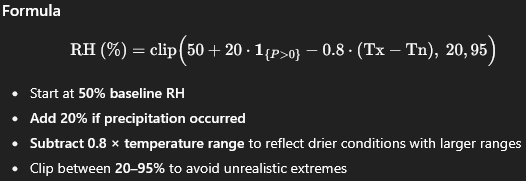
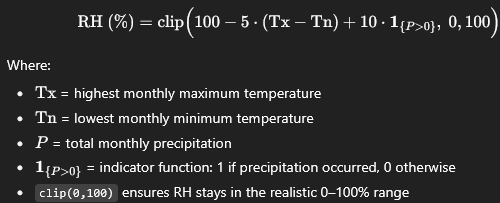

In [20]:
climate_final = gpd.read_file("../data_raw/climate/climate_EPSG_final.gpkg")

In [21]:
# Base RH
climate_final['RH'] = 50 - 0.8 * (climate_final['Tx'] - climate_final['Tn'])

# Increase RH if there was precipitation
climate_final.loc[climate_final['P'] > 0, 'RH'] += 20

# Clip to realistic bounds
climate_final['RH'] = climate_final['RH'].clip(20, 95)


In [22]:
climate_final.head()

,Tm,Tx,Tn,P,S,S_G,Year,Month,Long,Lat,RH,geometry
0,4.7,13.0,-5.5,546.6,53.8,0.0,2020,1,-123.742,48.935,55.20,POINT (1165636.462 438056.769)
1,10.0,23.7,-6.0,15.0,0.0,0.0,2020,4,-121.934,50.684,46.24,POINT (1286985.38 638142.245)
2,9.6,23.2,-6.4,17.9,0.0,0.0,2020,4,-121.582,50.224,46.32,POINT (1314992.12 588535.267)
3,9.8,23.9,-6.4,15.9,0.0,0.0,2020,4,-121.582,50.224,45.76,POINT (1314992.12 588535.267)
4,4.4,21.0,-15.0,16.4,1.0,0.0,2020,4,-120.333,49.673,41.20,POINT (1408773.898 533790.485)


In [23]:
climate_final['RH'].describe()

count    15758.000000
mean        51.804366
std          6.785901
min         20.000000
25%         47.600000
50%         52.400000
75%         56.800000
max         67.200000
Name: RH, dtype: float64

In [24]:
climate_final.to_file("../data_raw/climate/climate_EPSG_HR.gpkg", driver="GPKG")

- [Feature Transformation (Scaling, Normalization)](#feature-transformation-scaling-normalization)  

---

- [Correlation Analysis](#correlation-analysis)  

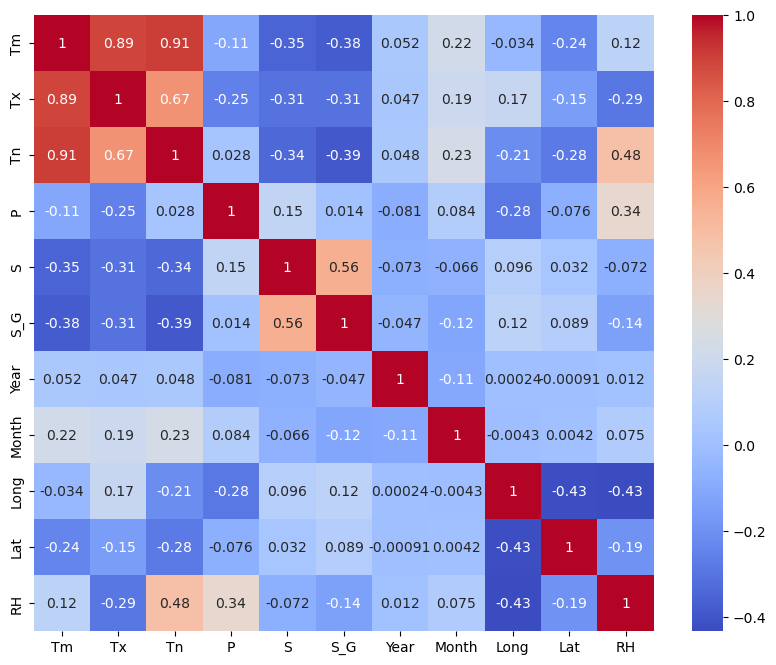

In [ ]:
numeric_cols = climate_final.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

Saving the preprocessed data

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# create geometry from Long, Lat
geometry = [Point(xy) for xy in zip(climate_gdf['Long'], climate_final['Lat'])]
climate_final = gpd.GeoDataFrame(climate_final, geometry=geometry, crs="EPSG:4326")  # start with lat/lon


In [7]:
# reproject to EPSG:3500
climate_final = climate_final.to_crs("EPSG:3005")

# save as GPKG
climate_final.to_file("../data_raw/climate/climate_EPSG_final.gpkg", driver="GPKG")

In [25]:
climate_normals = gpd.read_file("../data_raw/climate/climate_EPSG_HR.gpkg")

In [26]:
climate_normals.head()

,Tm,Tx,Tn,P,S,S_G,Year,Month,Long,Lat,RH,geometry
0,4.7,13.0,-5.5,546.6,53.8,0.0,2020,1,-123.742,48.935,55.20,POINT (1165636.462 438056.769)
1,10.0,23.7,-6.0,15.0,0.0,0.0,2020,4,-121.934,50.684,46.24,POINT (1286985.38 638142.245)
2,9.6,23.2,-6.4,17.9,0.0,0.0,2020,4,-121.582,50.224,46.32,POINT (1314992.12 588535.267)
3,9.8,23.9,-6.4,15.9,0.0,0.0,2020,4,-121.582,50.224,45.76,POINT (1314992.12 588535.267)
4,4.4,21.0,-15.0,16.4,1.0,0.0,2020,4,-120.333,49.673,41.20,POINT (1408773.898 533790.485)


In [27]:
climate_normals.columns

Index(['Tm', 'Tx', 'Tn', 'P', 'S', 'S_G', 'Year', 'Month', 'Long', 'Lat', 'RH',
       'geometry'],
      dtype='object')

In [28]:
# Compute long-term averages at each climate station
climate_normals = (
    climate_normals.groupby(["Long", "Lat"], as_index=False)
    .agg({
        "Tm": "mean",
        "Tx": "mean",
        "Tn": "mean",
        "P": "mean",
        "S": "mean",
        "S_G": "mean",
        "RH": "mean"
    })
)

# Rename columns with prefix
climate_normals = climate_normals.rename(columns={
    "Tm": "climate_Tm",
    "Tx": "climate_Tx",
    "Tn": "climate_Tn",
    "P": "climate_P",
    "S": "climate_S",
    "S_G": "climate_SG",
    "RH": "climate_RH"
})

climate_normals.head()


,Long,Lat,climate_Tm,climate_Tx,climate_Tn,climate_P,climate_S,climate_SG,climate_RH
0,-136.367,59.450,2.712500,13.791667,-9.270833,121.304167,48.050000,0.000000,49.883333
1,-133.700,59.567,-0.468750,11.750000,-15.281250,27.062500,15.187500,13.062500,48.375000
2,-133.058,54.255,8.209559,14.280882,2.366176,109.871324,1.332353,0.044118,60.174118
3,-132.772,53.316,8.807273,13.920000,3.616364,84.752727,0.000000,0.000000,61.029818
4,-132.125,54.027,7.901471,16.011765,-1.186765,53.700000,0.000000,0.000000,56.241176


In [29]:
climate_normals.shape

(255, 9)

In [32]:
# 1. Compute climate normals (still a pandas DataFrame)
climate_normals = (
    climate_normals
    .groupby(["Long", "Lat"], as_index=False)[["climate_Tm", "climate_Tx", "climate_Tn", "climate_P", "climate_S", "climate_SG", "climate_RH"]]
    .mean()
)

# 2. Convert back into GeoDataFrame, reusing the CRS from original
climate_normals = gpd.GeoDataFrame(
    climate_normals,
    geometry=gpd.points_from_xy(climate_normals["Long"], climate_normals["Lat"]),
    crs=climate_final.crs  # <-- not from climate_normals
)



In [33]:
climate_normals.to_file("../data_raw/climate/climate_normals_EPSG.gpkg", driver="GPKG")

In [36]:
climate_normals = gpd.read_file("../data_raw/climate/climate_EPSG_HR.gpkg")
climate_normals.bounds

,minx,miny,maxx,maxy
0,1.165636e+06,438056.768703,1.165636e+06,438056.768703
1,1.286985e+06,638142.244673,1.286985e+06,638142.244673
2,1.314992e+06,588535.266654,1.314992e+06,588535.266654
3,1.314992e+06,588535.266654,1.314992e+06,588535.266654
4,1.408774e+06,533790.485160,1.408774e+06,533790.485160
...,...,...,...,...
15753,1.218804e+06,455366.811140,1.218804e+06,455366.811140
15754,1.206418e+06,574015.037134,1.206418e+06,574015.037134
15755,1.294432e+06,462790.903299,1.294432e+06,462790.903299
15756,1.218147e+06,992350.996534,1.218147e+06,992350.996534


10. [References](#references)  


https://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?searchType=stnProv&timeframe=1&lstProvince=BC&optLimit=yearRange&StartYear=2015&EndYear=2025&Year=2025&Month=9&Day=12&selRowPerPage=25

https://governmentofbc.maps.arcgis.com/apps/webappviewer/index.html?id=c36baf74b74a46978cf517579a9ee332

https://climate.weather.gc.ca/prods_servs/cdn_climate_summary_e.html
